In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def random_seq(length=250):
    indices = np.random.randint(0, 3, size=(length))
    chars = ["a", "c", "g", "t"]
    sequence = []
    for index in indices:
        sequence.append(chars[index])
    
    return sequence

In [12]:
def get_reads_from(seq, read_len=200, coverage=5):
    L = len(seq)
    read_amt = int(L/read_len * coverage)
    reads = []
    for _ in range(read_amt):
        start = np.random.randint(0,L-read_len)
        read = seq[start:start+read_len]
        reads.append(read)
    return reads

In [4]:
def parse_nucleotides(sequence):
    new_seq = []
    map_to_vals = {"a": 1, "c": 2, "g": 3, "t":4}
    for symbol in sequence:
        new_seq.append(map_to_vals[symbol])
        
    return new_seq

In [5]:
def getskmer(snippet, profile):
    spaced_kmer = snippet * profile
    spaced_kmer = spaced_kmer[spaced_kmer != 0]
    s = ''.join(str(x) for x in spaced_kmer)
    return s

In [6]:
def get_maxcount(pos, seqs, seqs_kmers, spaced_kmer_profile, seq_to_investigate=0):
    target = seqs[seq_to_investigate]
    f = len(spaced_kmer_profile)
    counts_i = []
    indexes = []
    len_loop = min(f-1, pos)
    start = pos-len_loop
    end = pos+1
    for i in range(start, end):
        if spaced_kmer_profile[pos-i] != 1:
            counts_i.append(0)
            indexes.append(-1)
            continue
        
        # Extract k mers starting at selected position
        spaced_kmer = target[i : i+f] * spaced_kmer_profile
        spaced_kmer = spaced_kmer[spaced_kmer != 0]
        s = ''.join(str(x) for x in spaced_kmer)
        counts_i.append(seqs_kmers[s])
        indexes.append(i)
    
    return max(counts_i), indexes[np.argmax(counts_i)]

In [7]:
#
# CORRECT COUNTS - AN ATTEMPT AT FIXING THE ECLIPSE ERROR
#
def correct_counts(maxed_counts, maxed_count_indices, target_sequence, start_end_posis, seqs, diff_profile, kmer_profile):
    f = len(kmer_profile)
    correction_artifact = []
    last_correction = 0 
    # When corrections are necessary they are written into the maxed_counts array
    for i in range(1,len(maxed_count_indices)):
        # Make sure we have a change position on our hands.
        if maxed_counts[i] != maxed_counts[i-1]: 
            # Correct for reads that start in between the two maxed_count indices:
            #start_sum_at = max(i-f,0)
            #start_sum_at = max(0, maxed_count_indices[i-1]-f+1)
            '''
            start_sum_at = maxed_count_indices[i-1]
            end_sum_at = maxed_count_indices[i]+1
            if start_sum_at <= end_sum_at:
                correction = sum(start_end_posis[start_sum_at:end_sum_at])
            else:
                correction = -sum(start_end_posis[end_sum_at:start_sum_at])
            diff_profile[i-1] += correction
            correction_artifact.append([correction, (start_sum_at, end_sum_at), start_end_posis[start_sum_at:end_sum_at]])
            '''
            start_sum_at = last_correction
            end_sum_at = maxed_count_indices[i]+1
            #end_sum_at = i+1
            
            if start_sum_at <= end_sum_at:
                correction = sum(start_end_posis[start_sum_at:end_sum_at])
            else:
                correction = -sum(start_end_posis[end_sum_at:start_sum_at])
                
            # This if clause tries to prevent the eclipse
            # The important part of this is that the last_correction is not updated if we have a SNP or seqerr
            #if diff_profile[i-1] + correction == 0: # If not we have a SNP or seq error
            last_correction = maxed_count_indices[i] + 1
            diff_profile[i-1] += correction
            correction_artifact.append([correction, (start_sum_at, end_sum_at), start_end_posis[start_sum_at:end_sum_at]])
            
            #else:
                #print("ABORTED:")
                #print(end_sum_at)
                #print(start_end_posis[start_sum_at:end_sum_at])
    return diff_profile, correction_artifact

In [8]:
def get_correction_profile(target, seqs, overlap_size):
    corr_profile = [0 for i in range(len(target)-overlap_size)]
    #corr_profile[0] = -1
    for i in range(len(target)-overlap_size):
        #
        #if i == 0:
            # Note that this whole check is necessary because our target sequence, i.e. the read we are investigating at the moment
            # also starts at the beginning and would thus be added to the count profile. We anticipate this by increasing the correction
            # profile at this point to one s.t. the loop below can reduce it to zero in the first step if just our sequence starts there.
            # If another sequence starts here, then the loop below will reduce the correction profile below zero
            #corr_profile[0] = 1
        for seq in seqs:
            if (target[i : i+overlap_size] == seq[0 : overlap_size]).all(): # starts
                corr_profile[i] -= 1
            elif (target[i : i+overlap_size] == seq[len(seq)-overlap_size : len(seq)]).all(): # ends
                corr_profile[i] += 1
    corr_profile[0]=0
    return corr_profile

In [9]:
def correct_diff_profile(filename, str_profile, seq_to_investigate, data=[]):
    seqs = []
    if data:
        for read in data:
            sequence_chars = [val for val in read]
            sequence = parse_nucleotides(sequence_chars)
            seqs.append(np.array(sequence))
    else:
        with open(filename) as file_in:
            for line in file_in:
                newline = line.rstrip('\n')
                sequence_chars = [char for char in newline]
                sequence = parse_nucleotides(sequence_chars)
                seqs.append(np.array(sequence))
    
    profile = [int(character) for character in str_profile]
    k = sum(profile)
    f = len(profile)
    
    # Turn into np arrays for componentwise multiplication
    profile = np.array(profile)
    
    # Count occurence of spaced k-mers
    seqs_kmers = {}
    for sequence in seqs:
        for i in range(len(sequence) - f):
            spaced_kmer = sequence[i:i+f] * profile
            spaced_kmer = spaced_kmer[spaced_kmer != 0]
            s = ''.join(str(x) for x in spaced_kmer)
            if s not in seqs_kmers:
                seqs_kmers[s] = 1
            else:
                seqs_kmers[s] += 1
    
    # Get maxcounts from counts
    target = seqs[seq_to_investigate]
    xpoints = np.array([i for i in range(len(target) - f)])
    max_counts = []
    max_count_indices = []
    for i in range(len(xpoints)):
        maxp, argmaxp = get_maxcount(i, seqs, seqs_kmers, profile, seq_to_investigate=seq_to_investigate)
        max_counts.append(maxp)
        max_count_indices.append(argmaxp)
    #print(max_count_indices)
    # Get correction profile:
    start_end_posis = get_correction_profile(target, seqs, f)
    #print(start_end_posis)
    #print(max_count_indices)
    
    # Get diff profile:
    pre_corr_diff_profile = [max_counts[j] - max_counts[j-1] for j in range(1,len(max_counts))]
    
    # Apply correction strategy
    ypoints, correction_artifact = correct_counts(max_counts, max_count_indices, target, start_end_posis, seqs, pre_corr_diff_profile.copy(), profile)
    return xpoints[1:], ypoints, max_counts, start_end_posis, pre_corr_diff_profile, correction_artifact, max_count_indices


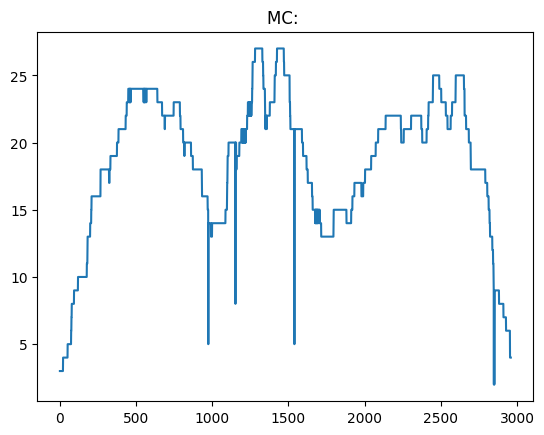

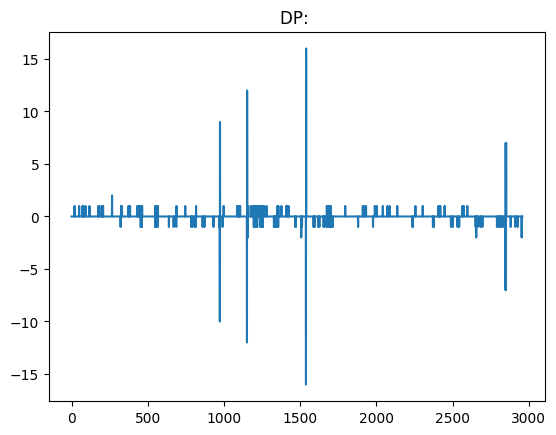

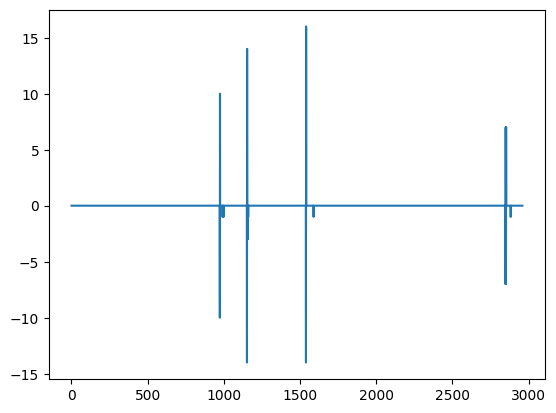

In [10]:
# Execute the function we created above on the circular synthetic data.
xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 1)
#
plt.title("MC: ")
plt.plot([i for i in range(len(pc_diff_profile)+1)], maxcounts)
plt.show()
#
plt.title("DP: ")
plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
#plt.savefig('snp_eclipse_dp.png', bbox_inches='tight')
plt.show()

# Plot
plt.plot(xpoints, ypoints)
#plt.savefig('snp_ecl_fixed.png', bbox_inches='tight')
plt.show()

# SNP eclipse amplitude measurements

In [12]:
with open("data/longseq.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

longseq = seqs[0]

# Min coverage and ratio
ratio = 3
for minCov in range(6,11):
    
    # We now want to make multiple rounds of introducing permutations in the second strain and checking how high the irregular amplitudes are
    rounds = 10
    max_irregular_amplitudes = []
    for _ in range(rounds):
        strain2 = longseq.copy()
    
        # get coverages
        cov1 = minCov
        cov2 = cov1*ratio
        
        # Create second strain
        mistake_no = 6
        for _ in range(mistake_no):
            index = np.random.randint(0,len(strain2)-30)
            val = strain2[index]
            possible_vals = ["c", "g", "t", "a"]
            possible_vals.remove(val)
            other_val = possible_vals[np.random.randint(0,len(possible_vals))]
            #print(str(index) +": " +str(val)+ "->"+ str(other_val))
            strain2[index] = other_val
    
        # Now get reads from both strains
        reads1 = get_reads_from(longseq, read_len=250, coverage=cov2)
        reads2 = get_reads_from(strain2, read_len=250, coverage=cov1)
    
        # Combine them
        allReads = reads1 + reads2
    
        # Add the full genomes to the read collection
        allReads.insert(0, longseq)
        allReads.insert(0, strain2)
        
        # Send it to the correction algorithm
        xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 1, data=allReads)
        # Sort array s.t. we can ignore the five largest amplitudes easily in the next step
        sorted_points = np.sort(ypoints)
        
        # Add the next largest element to the max_ampl array:
        #print(sorted_points[len(sorted_points)-4*mistake_no:])
        max_irregular_amplitudes.append(sorted_points[len(sorted_points)-mistake_no-1])
    print("cov: " + str(minCov))
    print(max_irregular_amplitudes)
    print("---------")

cov: 6
[1, 1, 2, 1, 1, 1, 1, 1, 1, 1]
---------
cov: 7
[1, 2, 2, 0, 1, 1, 3, 1, 2, 3]
---------
cov: 8
[2, 1, 1, 2, 1, 3, 0, 1, 1, 2]
---------
cov: 9
[2, 3, 2, 1, 2, 2, 1, 1, 2, 1]
---------
cov: 10
[3, 1, 1, 1, 3, 1, 2, 1, 2, 3]
---------


# Test a bunch of data for repeats

Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
537
['g', 't', 'a', 'a', 'c', 'c', 'g', 't', 'c', 'c', 'a', 'c']
2345
['a', 'a', 't', 't', 'g', 'c', 'c', 't', 'c', 'c', 'a', 'c']
Not correct: 4
[537, 790, 2345, 2598]


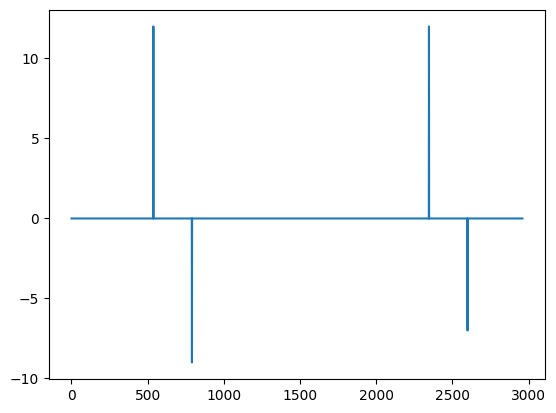

Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
Correct!
cov: 10
[]
---------


In [75]:
with open("data/longseq.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

longseq = seqs[0]

# We now want to make multiple rounds of introducing permutations in the second strain and checking how high the irregular amplitudes are
rounds = 50
minCov = 10
max_irregular_amplitudes = []
for _ in range(rounds):
    seq_copy = longseq.copy()
    R = random_seq()
    
    # pick random positions to insert the repetitions in.
    pos1 = np.random.randint(len(R),int(len(longseq)/2))
    pos2 = np.random.randint(int(len(longseq)/2)+len(R),len(longseq)-2*len(R))

    # insert repeats
    seq_with_reps = seq_copy[:pos1] + R + seq_copy[pos1+len(R):pos2] + R + seq_copy[pos2 + len(R):]
    
    # Now get reads from both strains
    reads = get_reads_from(seq_with_reps, read_len=250, coverage=minCov)

    # Add the full genomes to the read collection
    reads.insert(0, seq_with_reps)
    
    # Send it to the correction algorithm
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 0, data=reads)

    # get positions where repeats are detected
    posis_of_interest = [i for i in range(len(ypoints)) if ypoints[i] != 0]
    if len(posis_of_interest) > 4:
        print("More spikes")
        print([i for i in range(len(ypoints)) if ypoints[i] != 0])
        plt.plot(xpoints, ypoints)
        plt.show()
        continue
    elif len(posis_of_interest) < 4:
        print([i for i in range(len(ypoints)) if ypoints[i] != 0])
        plt.plot(xpoints, ypoints)
        plt.show()
        print("less spikes")
        xpoints_solid, ypoints_solid, _, _, _, _, _ = correct_diff_profile("./data/twostrains.txt", "111111111111111111111111111111", 0, data=reads)
        plt.plot(xpoints, ypoints)
        plt.show()
        continue
    
    # Check if these positions correctly correspond to the repeat regions
    posis_to_compare_with = [pos1, pos1+len(R), pos2, pos2+len(R)]
    all_correct = True
    differences = 0
    diff_index = 0
    for i in range(len(posis_to_compare_with)):
        anticipated_posi = posis_to_compare_with[i]
        actual_posi = posis_of_interest[i]
        actual_pos_range = [i for i in range(actual_posi - 4, actual_posi + 4)]
        if not anticipated_posi in actual_pos_range:
            all_correct = False
            differences = anticipated_posi - actual_posi
            if differences > 0:
                posis_to_show = [seq_with_reps[i] for i in range(actual_posi - differences-2, anticipated_posi+2)]
                print(actual_posi)
                print(posis_to_show)
            else:
                print([seq_with_reps[i] for i in range(anticipated_posi-2, actual_posi - differences+2)])
            #print([seq_with_reps[anticipated_posi+i] for i in range(-5,5)])
            #print("correct! difference is " + str(anticipated_posi - actual_posi))
        #else:
            #print("wrong by: " + str(anticipated_posi - actual_posi))
    if all_correct: print("Correct!")
    else: 
        print("Not correct: " + str(differences))
        print([i for i in range(len(ypoints)) if ypoints[i] != 0])
        plt.plot(xpoints, ypoints)
        plt.show()

print("cov: " + str(minCov))
print(max_irregular_amplitudes)
print("---------")

# Test spaced vs solid k-mers

In [37]:
with open("data/longseq.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

longseq = seqs[0]

# Min coverage and ratio
ratio = 2
for minCov in range(5,11):
    
    # We now want to make multiple rounds of introducing permutations in the second strain and checking how high the irregular amplitudes are
    rounds = 7
    max_irregular_amplitudes = []
    max_irregular_amplitudes_solid = []
    max_regular = []
    max_regular_solid = []
    max_diff = []
    for _ in range(rounds):
        strain2 = longseq.copy()
    
        # get coverages
        cov1 = minCov
        cov2 = cov1*ratio
        
        # Create second strain
        mistake_no = 5
        for _ in range(mistake_no):
            index = np.random.randint(0,len(strain2)-30)
            val = strain2[index]
            possible_vals = ["c", "g", "t", "a"]
            possible_vals.remove(val)
            other_val = possible_vals[np.random.randint(0,len(possible_vals))]
            #print(str(index) +": " +str(val)+ "->"+ str(other_val))
            strain2[index] = other_val
    
        # Now get reads from both strains
        reads1 = get_reads_from(longseq, read_len=250, coverage=cov2)
        reads2 = get_reads_from(strain2, read_len=250, coverage=cov1)
    
        # Combine them
        allReads = reads1 + reads2
    
        # Add the full genomes to the read collection
        allReads.insert(0, longseq)
        allReads.insert(0, strain2)
        
        # Send it to the correction algorithm
        xpoints, ypoints, _, _, _, _, _ = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 1, data=allReads)
        xpoints_solid, ypoints_solid, _, _, _, _, _ = correct_diff_profile("./data/twostrains.txt", "111111111111111111111111111111", 1, data=allReads)
        # Sort array s.t. we can ignore the five largest amplitudes easily in the next step
        sorted_points = np.sort(ypoints)
        sorted_points_solid = np.sort(ypoints_solid)
        
        # Add the next largest element to the max_ampl array:
        #print(sorted_points[len(sorted_points)-4*mistake_no:])
        irr_points = sorted_points[len(sorted_points)-mistake_no-1]
        irr_points_solid = sorted_points_solid[len(sorted_points_solid)-mistake_no-1]
        max_irregular_amplitudes.append(irr_points)
        max_irregular_amplitudes_solid.append(irr_points_solid)
        
        reg_points = sorted_points[len(sorted_points)-mistake_no:]
        reg_points_solid = sorted_points_solid[len(sorted_points_solid)-mistake_no:]
        max_diff.append(max(reg_points-reg_points_solid))
        if 0 in reg_points_solid:
            print("SNP got corrected away")
            print("reg: " + str(reg_points))
            print("solid: " + str(reg_points_solid))
            plt.plot(xpoints, ypoints)
            plt.show()
            plt.plot(xpoints_solid, ypoints_solid)
            plt.show()
        max_regular.append(reg_points)
        max_regular_solid.append(reg_points_solid)
    '''
    print("cov: " + str(minCov))
    print("SNP amplitudes:")
    print(max_regular)
    print(max_regular_solid)
    print("After SNP")
    print("spaced: " + str(max_irregular_amplitudes))
    print("solid: " + str(max_irregular_amplitudes_solid))
    '''
    print(max_diff)
    print("---------")

KeyboardInterrupt: 

## SNPs > amplitude detection

In [38]:
with open("data/longseq.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

longseq = seqs[0]

# Min coverage and ratio
minCov = 6
success_rate = []
for ratio in [2+i*0.2 for i in range(11)]:
    
    # We now want to make multiple rounds of introducing permutations in the second strain and checking how high the irregular amplitudes are
    rounds = 10
    SNPs = []
    success = 0
    fail = 0
    for _ in range(rounds):
        strain2 = longseq.copy()
    
        # get coverages
        cov1 = minCov
        cov2 = cov1*ratio
        
        # Create second strain
        mistake_no = 6
        SNP_posis = []
        for _ in range(mistake_no):
            index = np.random.randint(0,len(strain2)-30)
            SNP_posis.append(index)
            val = strain2[index]
            possible_vals = ["c", "g", "t", "a"]
            possible_vals.remove(val)
            other_val = possible_vals[np.random.randint(0,len(possible_vals))]
            #print(str(index) +": " +str(val)+ "->"+ str(other_val))
            strain2[index] = other_val
    
        # Now get reads from both strains
        reads1 = get_reads_from(longseq, read_len=250, coverage=cov2)
        reads2 = get_reads_from(strain2, read_len=250, coverage=cov1)
    
        # Combine them
        allReads = reads1 + reads2
    
        # Add the full genomes to the read collection
        allReads.insert(0, longseq)
        allReads.insert(0, strain2)
        
        # Send it to the correction algorithm
        xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 0, data=allReads)
        # Sort array s.t. we can ignore the five largest amplitudes easily in the next step
        #sorted_points = np.sort(ypoints)
        
        # Add the next largest element to the max_ampl array:
        #print(sorted_points[len(sorted_points)-4*mistake_no:])
        ypoints = np.array(ypoints)
        estimated_SNP_posis = np.argwhere(ypoints > 3)
        estimated_SNP_posis.shape = (len(estimated_SNP_posis),)
        print(SNP_posis)
        print(estimated_SNP_posis)
        if len(SNP_posis) == len(estimated_SNP_posis) and (np.sort(SNP_posis) == estimated_SNP_posis).all():
            success += 1
        else:
            #print(np.sort(SNP_posis) == estimated_SNP_posis)
            fail += 1
        print("---------")
    success_rate.append(success/(success + fail))
    print("cov: " + str(minCov))
    print(fail)
    print(success/(success + fail))
    #print(max_irregular_amplitudes)
    print("---------")
print(success_rate)

[1335, 1735, 2945, 1484, 339, 1662]
[ 339 1335 1484 1662 1735 2945]
---------
[877, 298, 665, 2262, 125, 813]
[ 125  298  665  813  877 2262]
---------
[79, 1809, 408, 2078, 234, 1063]
[  79  234  408 1063 1809 2078]
---------
[1964, 2143, 634, 2661, 2101, 760]
[ 634  760 1964 2101 2143 2661]
---------
[1282, 1906, 1726, 584, 1245, 2594]
[ 584 1245 1282 1726 1906 2594]
---------
[2602, 2556, 1752, 790, 2136, 1266]
[ 790 1266 1752 2136 2556 2602]
---------
[1540, 2302, 403, 1169, 209, 723]
[ 209  403  723 1169 1540 2302]
---------
[1413, 1801, 182, 2411, 2780, 2239]
[ 182 1413 1801 2239 2411 2780]
---------
[433, 2814, 1446, 2902, 1890, 1470]
[ 433 1446 1470 1890 2814 2902]
---------
[2183, 1522, 1424, 1246, 1138, 1253]
[1138 1246 1253 1424 1522 2183]
---------
cov: 6
0
1.0
---------
[1625, 508, 2592, 2929, 2120, 2439]
[ 508 1625 2120 2439 2592]
---------
[2697, 2209, 1649, 117, 2377, 994]
[ 117  994 1649 2209 2377 2697]
---------
[2411, 2861, 132, 2883, 221, 2968]
[ 132  221 2411 2861 

### For a solid k-mer

In [35]:
with open("data/longseq.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

longseq = seqs[0]

# Min coverage and ratio
minCov = 6
success_rate = []
for ratio in [2+i*0.2 for i in range(11)]:
    
    # We now want to make multiple rounds of introducing permutations in the second strain and checking how high the irregular amplitudes are
    rounds = 10
    SNPs = []
    success = 0
    fail = 0
    for _ in range(rounds):
        strain2 = longseq.copy()
    
        # get coverages
        cov1 = minCov
        cov2 = cov1*ratio
        
        # Create second strain
        mistake_no = 6
        SNP_posis = []
        for _ in range(mistake_no):
            index = np.random.randint(0,len(strain2)-30)
            SNP_posis.append(index)
            val = strain2[index]
            possible_vals = ["c", "g", "t", "a"]
            possible_vals.remove(val)
            other_val = possible_vals[np.random.randint(0,len(possible_vals))]
            #print(str(index) +": " +str(val)+ "->"+ str(other_val))
            strain2[index] = other_val
    
        # Now get reads from both strains
        reads1 = get_reads_from(longseq, read_len=250, coverage=cov2)
        reads2 = get_reads_from(strain2, read_len=250, coverage=cov1)
    
        # Combine them
        allReads = reads1 + reads2
    
        # Add the full genomes to the read collection
        allReads.insert(0, longseq)
        allReads.insert(0, strain2)
        
        # Send it to the correction algorithm
        xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 0, data=allReads)
        xpoints, ypoints_solid, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "111111111111111111111111111111", 0, data=allReads)
        # Sort array s.t. we can ignore the five largest amplitudes easily in the next step
        #sorted_points = np.sort(ypoints)
        
        # Add the next largest element to the max_ampl array:
        #print(sorted_points[len(sorted_points)-4*mistake_no:])
        ypoints = np.array(ypoints)
        estimated_SNP_posis = np.argwhere(ypoints > 3)
        estimated_SNP_posis.shape = (len(estimated_SNP_posis),)

        ypoints_solid = np.array(ypoints_solid)
        estimated_SNP_posis_solid = np.argwhere(ypoints_solid > 0)
        estimated_SNP_posis_solid.shape = (len(estimated_SNP_posis_solid),)
        
        all_est_posis = np.concatenate((estimated_SNP_posis, estimated_SNP_posis_solid))
        all_est_posis = np.unique(all_est_posis)
        print(all_est_posis)
        if len(SNP_posis) == len(all_est_posis) and (np.sort(SNP_posis) == all_est_posis).all():
            success += 1
        else:
            #print(np.sort(SNP_posis) == estimated_SNP_posis)
            for pos in SNP_posis:
                if pos not in all_est_posis:
                    print("Error Pos: " + str(pos) + ". Value at error pos: " + str(ypoints_solid[pos]))
            fail += 1
        print("---------")
    success_rate.append(success/(success + fail))
    print("ratio: " + str(ratio))
    print(fail)
    print(success/(success + fail))
    #print(max_irregular_amplitudes)
    print("---------")
print(success_rate)

[1134 1403 1866 2296 2590 2687]
---------
[ 683  697  776 1036 1329 1844]
---------
[ 204  420  501 1763 2025 2413]
---------
[ 134  725  789 1331 1655 1659]
---------
[ 252  603  773 1562 2086 2368]
---------
[ 120  651  692 2295 2593 2691]
---------
[ 915  921 1205 2058 2063 2952]
---------
[  10  933  957 1264 1718 2021]
---------
[   0  152  307  821 1391 2532]
---------
[ 130 2119 2274 2312 2452 2789]
---------
ratio: 2.0
0
1.0
---------
[ 501  939 1248 1361 1961 2045]
---------
[1196 1750 2024 2328 2586 2832]
---------
[ 264  443  505  839 1068 2200]
---------
[ 128  270 1074 1575 1795 1863]
---------
[ 556 2383 2443 2523 2922 2952]
---------
[ 412 1134 1197 1962 2151 2565]
---------
[1637 1653 1751 1790 2053 2947]
---------
[1209 1550 1716 1768 1904 2878]
---------
[ 160  512 1179 1263 2506 2914]
---------
[ 207  921 1017 1358 1580 2130]
---------
ratio: 2.2
0
1.0
---------
[ 552  627 1040 1505 2229 2930]
---------
[ 458  699 1567 1919 2055 2178]
---------
[1115 1248 1807 1852 2

# 5-10% are SNPs

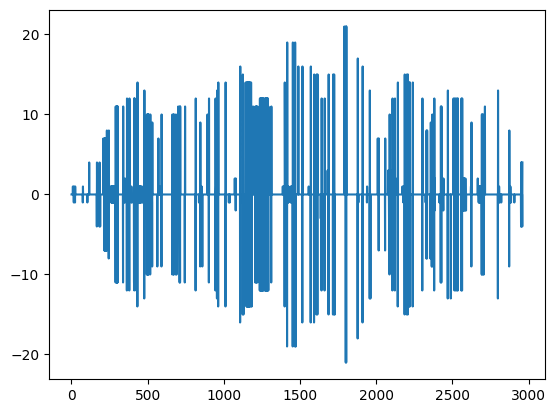

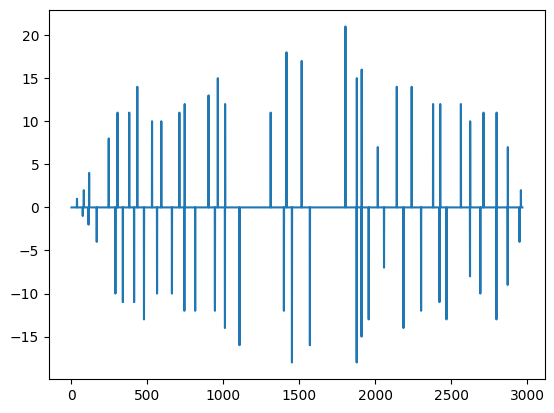

diff = -1 of 150
Error Pos: 206. Value at error pos: 0
Error Pos: 2493. Value at error pos: 0
Error Pos: 2356. Value at error pos: 0
Error Pos: 1746. Value at error pos: 0
Error Pos: 865. Value at error pos: 0
Error Pos: 1985. Value at error pos: 0
Error Pos: 1189. Value at error pos: 0
Error Pos: 1779. Value at error pos: 0
Error Pos: 1964. Value at error pos: 0
Error Pos: 113. Value at error pos: 0
Error Pos: 1758. Value at error pos: 0
Error Pos: 115. Value at error pos: 0
Error Pos: 1965. Value at error pos: 0
Error Pos: 191. Value at error pos: 0
Error Pos: 1995. Value at error pos: 0
Error Pos: 1763. Value at error pos: 0
Error Pos: 2847. Value at error pos: 0
Error Pos: 691. Value at error pos: 0
Error Pos: 75. Value at error pos: 0
Error Pos: 24. Value at error pos: 0
Error Pos: 873. Value at error pos: 0
Error Pos: 1135. Value at error pos: 0
Error Pos: 1975. Value at error pos: 0
Error Pos: 1487. Value at error pos: 0
Error Pos: 881. Value at error pos: 0
Error Pos: 1184. Val

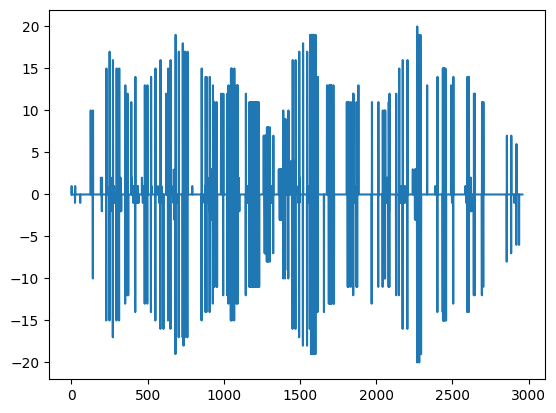

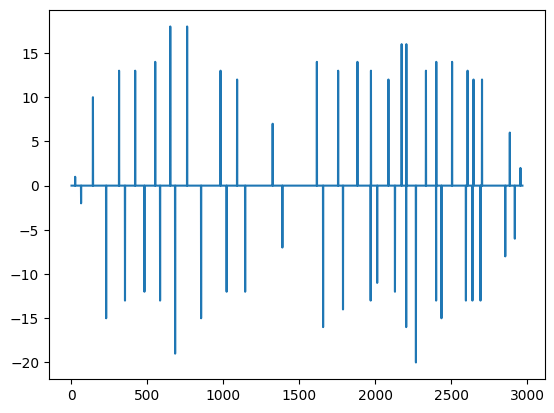

diff = 4 of 150
Error Pos: 123. Value at error pos: 0
Error Pos: 2321. Value at error pos: 0
Error Pos: 1875. Value at error pos: 0
Error Pos: 2329. Value at error pos: 0
Error Pos: 978. Value at error pos: 0
Error Pos: 975. Value at error pos: 0
Error Pos: 1879. Value at error pos: 0
Error Pos: 2149. Value at error pos: 0
Error Pos: 1658. Value at error pos: 0
Error Pos: 604. Value at error pos: 0
Error Pos: 1970. Value at error pos: 0
Error Pos: 111. Value at error pos: 0
Error Pos: 2479. Value at error pos: 0
Error Pos: 124. Value at error pos: 0
Error Pos: 2954. Value at error pos: 0
Error Pos: 1236. Value at error pos: 0
Error Pos: 1805. Value at error pos: 0
Error Pos: 608. Value at error pos: 0
Error Pos: 79. Value at error pos: 0
Error Pos: 81. Value at error pos: 0
Error Pos: 378. Value at error pos: 0
Error Pos: 2937. Value at error pos: 0
Error Pos: 89. Value at error pos: 0
Error Pos: 68. Value at error pos: 0
Error Pos: 1751. Value at error pos: 0
Error Pos: 1251. Value at

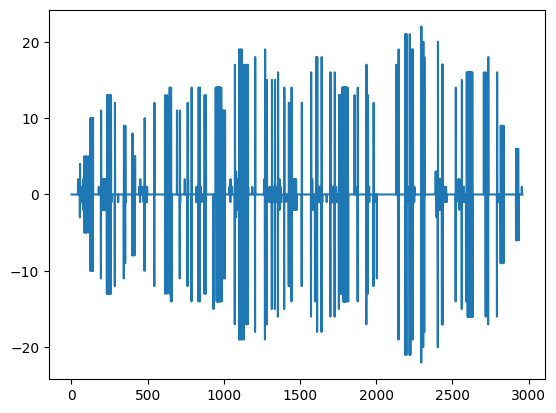

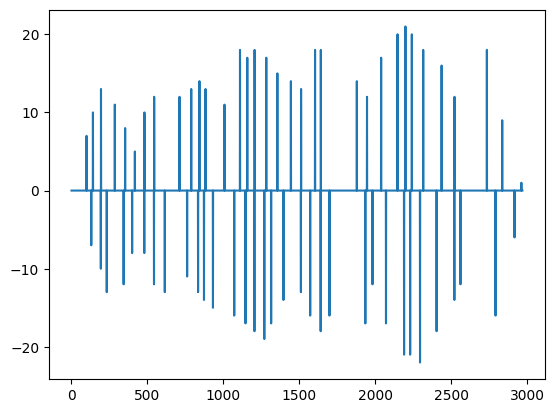

diff = 10 of 150
Error Pos: 2004. Value at error pos: 0
Error Pos: 36. Value at error pos: 0
Error Pos: 2656. Value at error pos: 0
Error Pos: 2104. Value at error pos: 0
Error Pos: 2031. Value at error pos: 0
Error Pos: 2670. Value at error pos: 0
Error Pos: 12. Value at error pos: 0
Error Pos: 2230. Value at error pos: 0
Error Pos: 2231. Value at error pos: 0
Error Pos: 2942. Value at error pos: 0
Error Pos: 2071. Value at error pos: 0
Error Pos: 989. Value at error pos: 0
Error Pos: 1600. Value at error pos: 0
Error Pos: 2082. Value at error pos: 0
Error Pos: 691. Value at error pos: 0
Error Pos: 942. Value at error pos: 0
Error Pos: 2693. Value at error pos: 0
Error Pos: 2672. Value at error pos: 0
Error Pos: 1002. Value at error pos: 0
Error Pos: 2126. Value at error pos: 0
Error Pos: 2668. Value at error pos: 0
Error Pos: 1816. Value at error pos: 0
Error Pos: 2087. Value at error pos: 0
Error Pos: 2589. Value at error pos: 0
Error Pos: 935. Value at error pos: 0
Error Pos: 1774.

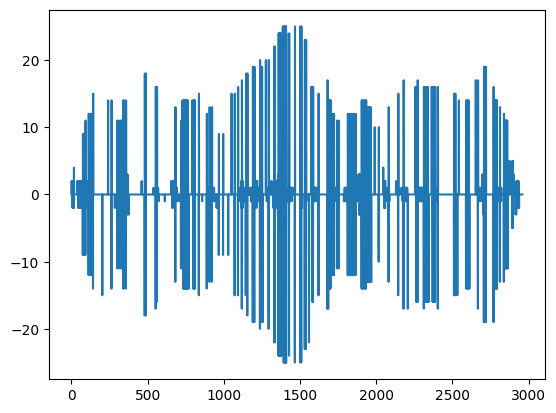

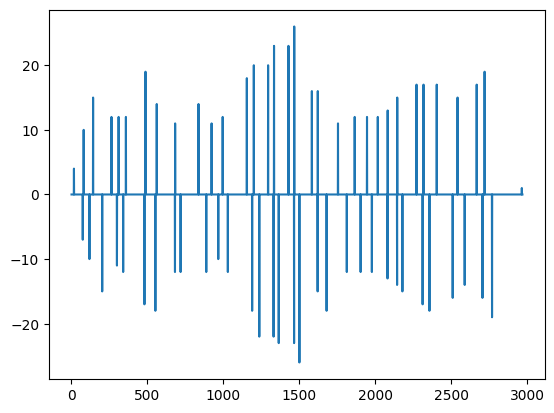

diff = -26 of 150
Error Pos: 204. Value at error pos: 0
Error Pos: 779. Value at error pos: 0
Error Pos: 14. Value at error pos: 0
Error Pos: 1144. Value at error pos: 0
Error Pos: 2923. Value at error pos: 0
Error Pos: 2636. Value at error pos: 0
Error Pos: 1379. Value at error pos: 0
Error Pos: 2218. Value at error pos: 0
Error Pos: 1978. Value at error pos: 0
Error Pos: 2939. Value at error pos: 0
Error Pos: 2358. Value at error pos: 0
Error Pos: 1033. Value at error pos: 0
Error Pos: 792. Value at error pos: 0
Error Pos: 785. Value at error pos: 0
Error Pos: 203. Value at error pos: 0
Error Pos: 2647. Value at error pos: 0
Error Pos: 2208. Value at error pos: 0
Error Pos: 1044. Value at error pos: 0
Error Pos: 1040. Value at error pos: 0
Error Pos: 2357. Value at error pos: 0
Error Pos: 2210. Value at error pos: 0
Error Pos: 2225. Value at error pos: 0
Error Pos: 2617. Value at error pos: 0
Error Pos: 1571. Value at error pos: 0
Error Pos: 2651. Value at error pos: 0
Error Pos: 156

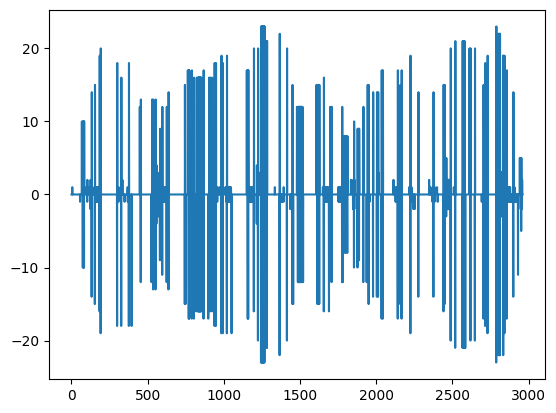

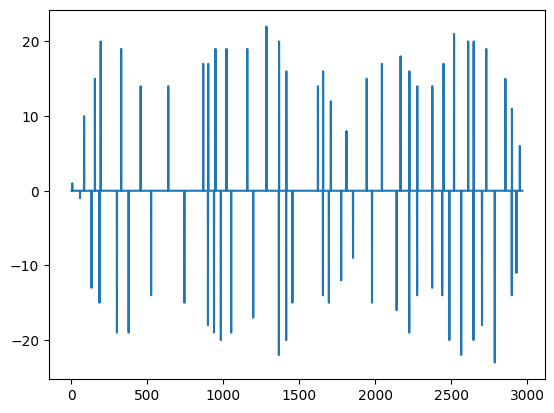

diff = 12 of 150
Error Pos: 761. Value at error pos: 0
Error Pos: 1469. Value at error pos: 0
Error Pos: 1787. Value at error pos: 0
Error Pos: 1100. Value at error pos: 0
Error Pos: 1552. Value at error pos: 0
Error Pos: 1052. Value at error pos: 0
Error Pos: 1464. Value at error pos: 0
Error Pos: 1526. Value at error pos: 0
Error Pos: 1074. Value at error pos: 0
Error Pos: 56. Value at error pos: -1
Error Pos: 1591. Value at error pos: 0
Error Pos: 1475. Value at error pos: 0
Error Pos: 750. Value at error pos: 0
Error Pos: 1554. Value at error pos: 0
Error Pos: 2934. Value at error pos: 0
Error Pos: 1455. Value at error pos: 0
Error Pos: 1082. Value at error pos: 0
Error Pos: 1940. Value at error pos: 0
Error Pos: 1053. Value at error pos: 0
Error Pos: 1758. Value at error pos: 0
Error Pos: 1592. Value at error pos: 0
Error Pos: 899. Value at error pos: 0
Error Pos: 437. Value at error pos: 0
Error Pos: 1939. Value at error pos: 0
Error Pos: 1788. Value at error pos: 0
Error Pos: 48

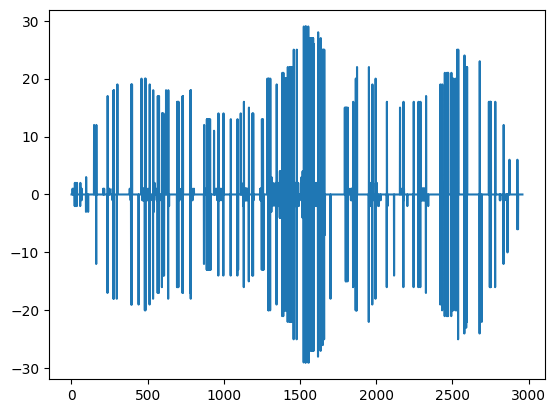

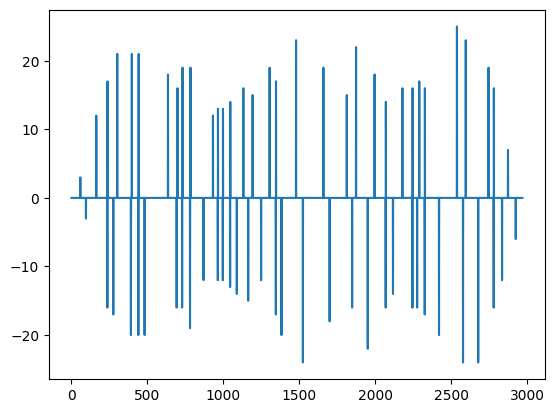

diff = 8 of 150
Error Pos: 110. Value at error pos: 0
Error Pos: 1704. Value at error pos: 0
Error Pos: 300. Value at error pos: 0
Error Pos: 1702. Value at error pos: 0
Error Pos: 2959. Value at error pos: 0
Error Pos: 4. Value at error pos: 0
Error Pos: 2696. Value at error pos: 0
Error Pos: 2714. Value at error pos: 0
Error Pos: 2940. Value at error pos: 0
Error Pos: 22. Value at error pos: 0
Error Pos: 485. Value at error pos: 0
Error Pos: 2693. Value at error pos: 0
Error Pos: 1759. Value at error pos: 0
Error Pos: 613. Value at error pos: 0
Error Pos: 1280. Value at error pos: 0
Error Pos: 1279. Value at error pos: 0
Error Pos: 1094. Value at error pos: 0
Error Pos: 617. Value at error pos: 0
Error Pos: 2868. Value at error pos: 0
Error Pos: 96. Value at error pos: 0
Error Pos: 441. Value at error pos: 0
Error Pos: 112. Value at error pos: 0
Error Pos: 36. Value at error pos: 0
Error Pos: 147. Value at error pos: 0
Error Pos: 2152. Value at error pos: 0
Error Pos: 144. Value at e

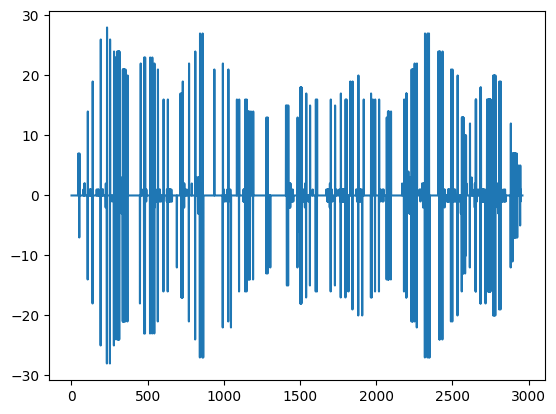

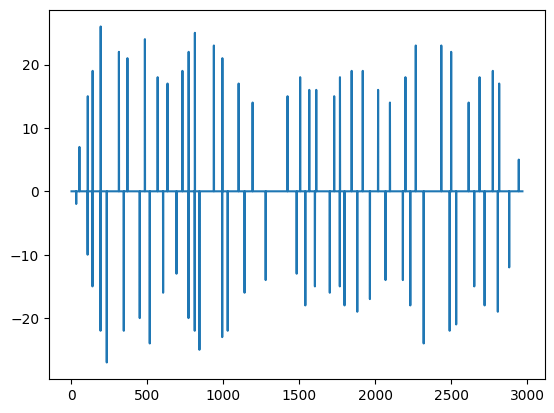

diff = 2 of 150
Error Pos: 1174. Value at error pos: 0
Error Pos: 1051. Value at error pos: 0
Error Pos: 911. Value at error pos: 0
Error Pos: 886. Value at error pos: 0
Error Pos: 692. Value at error pos: 0
Error Pos: 1305. Value at error pos: 0
Error Pos: 2379. Value at error pos: 0
Error Pos: 450. Value at error pos: 0
Error Pos: 2361. Value at error pos: 0
Error Pos: 2725. Value at error pos: 0
Error Pos: 1397. Value at error pos: 0
Error Pos: 1327. Value at error pos: 0
Error Pos: 1350. Value at error pos: 0
Error Pos: 1403. Value at error pos: 0
Error Pos: 1324. Value at error pos: 0
Error Pos: 2387. Value at error pos: 0
Error Pos: 1084. Value at error pos: 0
Error Pos: 1975. Value at error pos: 0
Error Pos: 712. Value at error pos: 0
Error Pos: 2720. Value at error pos: 0
Error Pos: 2361. Value at error pos: 0
Error Pos: 1053. Value at error pos: 0
Error Pos: 1373. Value at error pos: 0
Error Pos: 1367. Value at error pos: 0
Error Pos: 1377. Value at error pos: 0
Error Pos: 293

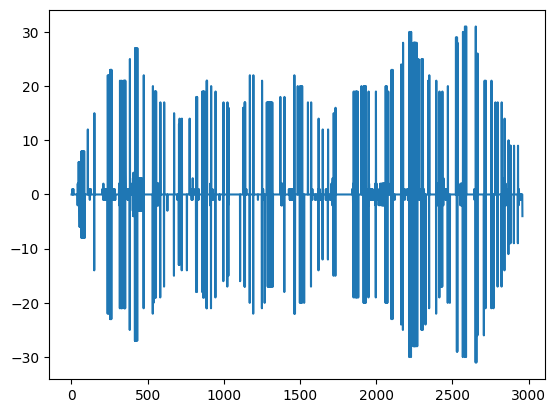

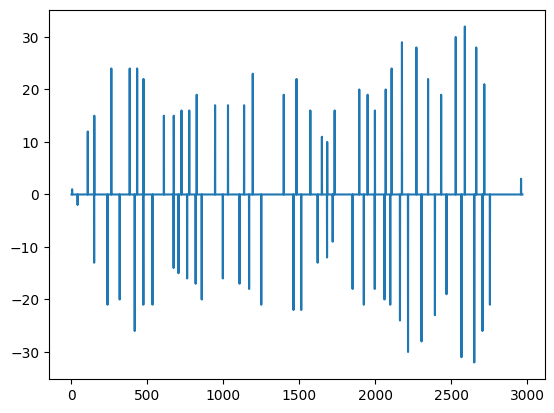

diff = -13 of 150
Error Pos: 2521. Value at error pos: 0
Error Pos: 2508. Value at error pos: 0
Error Pos: 539. Value at error pos: 0
Error Pos: 1125. Value at error pos: 0
Error Pos: 1108. Value at error pos: 0
Error Pos: 762. Value at error pos: 0
Error Pos: 2. Value at error pos: 0
Error Pos: 1369. Value at error pos: 0
Error Pos: 768. Value at error pos: 0
Error Pos: 106. Value at error pos: 0
Error Pos: 541. Value at error pos: 0
Error Pos: 764. Value at error pos: 0
Error Pos: 2707. Value at error pos: 0
Error Pos: 1337. Value at error pos: 0
Error Pos: 1889. Value at error pos: 0
Error Pos: 2269. Value at error pos: 0
Error Pos: 770. Value at error pos: 0
Error Pos: 41. Value at error pos: 0
Error Pos: 1476. Value at error pos: 0
Error Pos: 1534. Value at error pos: 0
Error Pos: 2485. Value at error pos: 0
Error Pos: 1538. Value at error pos: 0
Error Pos: 1268. Value at error pos: 0
Error Pos: 2486. Value at error pos: 0
Error Pos: 1468. Value at error pos: 0
Error Pos: 2483. Va

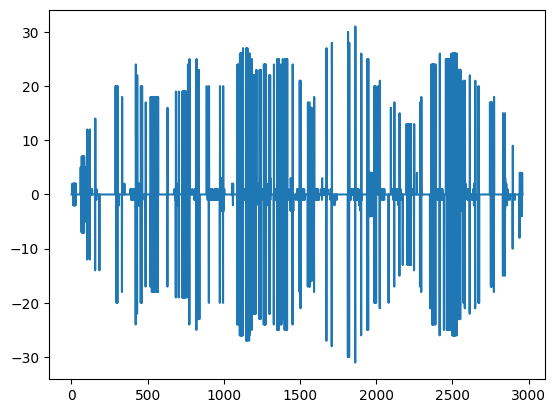

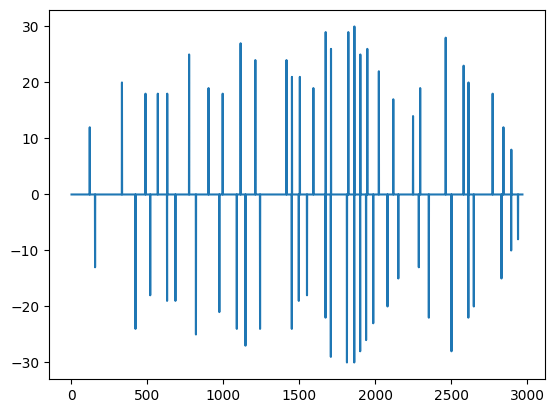

diff = -40 of 150
Error Pos: 2451. Value at error pos: 0
Error Pos: 186. Value at error pos: 0
Error Pos: 251. Value at error pos: 0
Error Pos: 54. Value at error pos: 0
Error Pos: 871. Value at error pos: 0
Error Pos: 2940. Value at error pos: 0
Error Pos: 2082. Value at error pos: 0
Error Pos: 2094. Value at error pos: 0
Error Pos: 203. Value at error pos: 0
Error Pos: 2354. Value at error pos: 0
Error Pos: 207. Value at error pos: 0
Error Pos: 191. Value at error pos: 0
Error Pos: 2353. Value at error pos: 0
Error Pos: 862. Value at error pos: 0
Error Pos: 27. Value at error pos: 0
Error Pos: 254. Value at error pos: 0
Error Pos: 227. Value at error pos: 0
Error Pos: 50. Value at error pos: 0
Error Pos: 2012. Value at error pos: 0
Error Pos: 274. Value at error pos: 0
Error Pos: 2455. Value at error pos: 0
Error Pos: 195. Value at error pos: 0
Error Pos: 2968. Value at error pos: 0
Error Pos: 1467. Value at error pos: 0
Error Pos: 2177. Value at error pos: 0
Error Pos: 2725. Value a

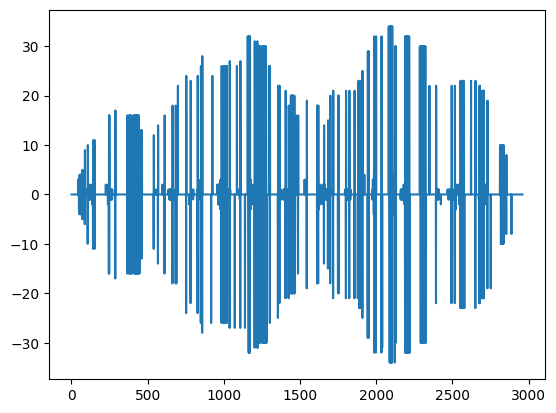

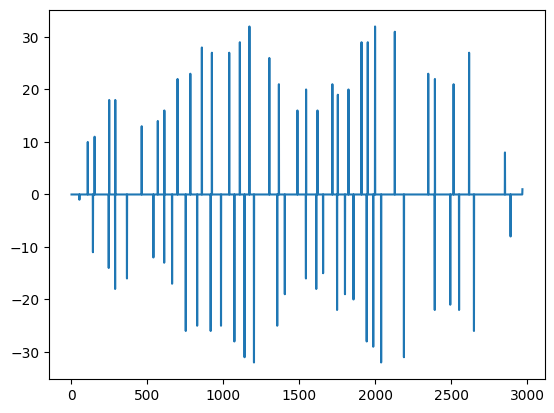

diff = -21 of 150
Error Pos: 1082. Value at error pos: 0
Error Pos: 2071. Value at error pos: 0
Error Pos: 2581. Value at error pos: 0
Error Pos: 2283. Value at error pos: 0
Error Pos: 2050. Value at error pos: 0
Error Pos: 2048. Value at error pos: 0
Error Pos: 405. Value at error pos: 0
Error Pos: 2895. Value at error pos: 0
Error Pos: 2891. Value at error pos: 0
Error Pos: 2252. Value at error pos: 0
Error Pos: 694. Value at error pos: 0
Error Pos: 2329. Value at error pos: 0
Error Pos: 2040. Value at error pos: 0
Error Pos: 2345. Value at error pos: 0
Error Pos: 919. Value at error pos: 0
Error Pos: 696. Value at error pos: 0
Error Pos: 2610. Value at error pos: 0
Error Pos: 693. Value at error pos: 0
Error Pos: 2077. Value at error pos: 0
Error Pos: 2231. Value at error pos: 0
Error Pos: 1155. Value at error pos: 0
Error Pos: 2766. Value at error pos: 0
Error Pos: 1074. Value at error pos: 0
Error Pos: 2793. Value at error pos: 0
Error Pos: 2919. Value at error pos: 0
Error Pos: 2

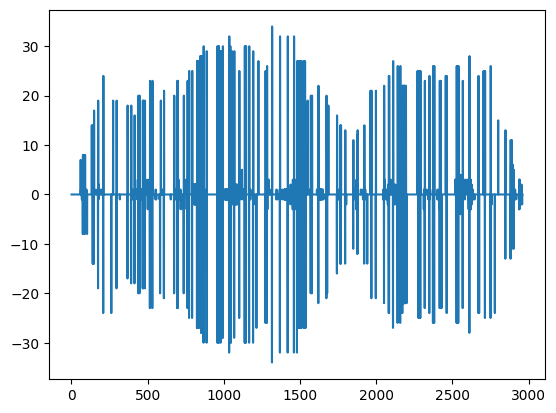

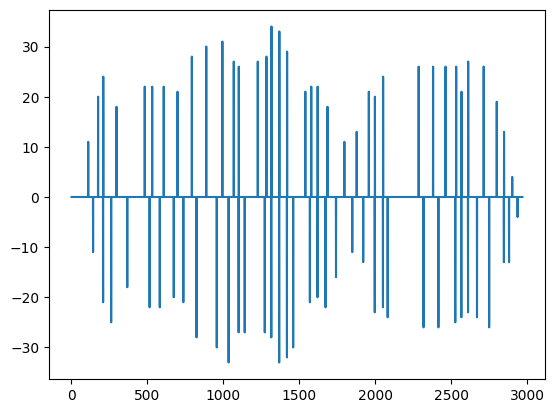

diff = 2 of 150
Error Pos: 2789. Value at error pos: 0
Error Pos: 46. Value at error pos: 0
Error Pos: 1051. Value at error pos: 0
Error Pos: 1224. Value at error pos: 0
Error Pos: 2247. Value at error pos: 0
Error Pos: 2952. Value at error pos: 0
Error Pos: 268. Value at error pos: 0
Error Pos: 2428. Value at error pos: 0
Error Pos: 1217. Value at error pos: 0
Error Pos: 14. Value at error pos: 0
Error Pos: 30. Value at error pos: 0
Error Pos: 2349. Value at error pos: 0
Error Pos: 2791. Value at error pos: 0
Error Pos: 1683. Value at error pos: 0
Error Pos: 4. Value at error pos: 0
Error Pos: 2778. Value at error pos: 0
Error Pos: 2436. Value at error pos: 0
Error Pos: 2266. Value at error pos: 0
Error Pos: 1954. Value at error pos: 0
Error Pos: 1538. Value at error pos: 0
Error Pos: 59. Value at error pos: 0
Error Pos: 2239. Value at error pos: 0
Error Pos: 2689. Value at error pos: 0
Error Pos: 2937. Value at error pos: 0
Error Pos: 2349. Value at error pos: 0
Error Pos: 53. Value 

In [20]:
with open("data/longseq.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

longseq = seqs[0]

# Min coverage and ratio
minCov = 6
success_rate = []
for ratio in [2+i*0.2 for i in range(11)]:
    
    # We now want to make multiple rounds of introducing permutations in the second strain and checking how high the irregular amplitudes are
    rounds = 1
    SNPs = []
    success = 0
    fail = 0
    for _ in range(rounds):
        strain2 = longseq.copy()
    
        # get coverages
        cov1 = minCov
        cov2 = cov1*ratio
        
        # Create second strain
        mistake_no = int(0.05 * len(longseq))
        SNP_posis = []
        for _ in range(mistake_no):
            index = np.random.randint(0,len(strain2)-30)
            SNP_posis.append(index)
            val = strain2[index]
            possible_vals = ["c", "g", "t", "a"]
            possible_vals.remove(val)
            other_val = possible_vals[np.random.randint(0,len(possible_vals))]
            #print(str(index) +": " +str(val)+ "->"+ str(other_val))
            strain2[index] = other_val
    
        # Now get reads from both strains
        reads1 = get_reads_from(longseq, read_len=250, coverage=cov2)
        reads2 = get_reads_from(strain2, read_len=250, coverage=cov1)
    
        # Combine them
        allReads = reads1 + reads2
    
        # Add the full genomes to the read collection
        allReads.insert(0, longseq)
        allReads.insert(0, strain2)
        
        # Send it to the correction algorithm
        xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 0, data=allReads)
        xpoints_solid, ypoints_solid, maxcounts, se, pc_diff_profile, artifact, mci = correct_diff_profile("./data/twostrains.txt", "111111111111111111111111111111", 0, data=allReads)
        # Sort array s.t. we can ignore the five largest amplitudes easily in the next step
        #sorted_points = np.sort(ypoints)
        plt.plot(xpoints, ypoints)
        plt.show()
        plt.plot(xpoints_solid, ypoints_solid)
        plt.show()
        # Add the next largest element to the max_ampl array:
        #print(sorted_points[len(sorted_points)-4*mistake_no:])
        ypoints = np.array(ypoints)
        estimated_SNP_posis = np.argwhere(ypoints > 3)
        estimated_SNP_posis.shape = (len(estimated_SNP_posis),)

        ypoints_solid = np.array(ypoints_solid)
        estimated_SNP_posis_solid = np.argwhere(ypoints_solid > 0)
        estimated_SNP_posis_solid.shape = (len(estimated_SNP_posis_solid),)
        
        all_est_posis = np.concatenate((estimated_SNP_posis, estimated_SNP_posis_solid))
        all_est_posis = np.unique(all_est_posis)
        print("diff = " + str(len(SNP_posis) - len(all_est_posis)) + " of " + str(len(SNP_posis)))
        if len(SNP_posis) == len(all_est_posis) and (np.sort(SNP_posis) == all_est_posis).all():
            success += 1
        else:
            #print(np.sort(SNP_posis) == estimated_SNP_posis)
            for pos in SNP_posis:
                if pos not in all_est_posis:
                    print("Error Pos: " + str(pos) + ". Value at error pos: " + str(ypoints_solid[pos]))
            fail += 1
        print("---------")
    success_rate.append(success/(success + fail))
    print("ratio: " + str(ratio))
    print(fail)
    print(success/(success + fail))
    #print(max_irregular_amplitudes)
    print("---------")
print(success_rate)